# Model building

In [198]:
import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, make_scorer
from sklearn.metrics import plot_roc_curve, precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer


from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import LSTM, Bidirectional, Conv1D
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import MaxPooling1D, GlobalMaxPool1D, BatchNormalization
from tensorflow.keras import backend as K
#from tensorflow.keras.layers.embeddings import Embedding

import datetime

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_orig = pd.read_csv("df_processed.csv")
df_orig.replace(np.nan, "no_text", inplace=True)

In [4]:
print ( df_orig.shape, df_orig.columns)
df_orig.head(2)

(541438, 21) Index(['Unnamed: 0', 'id', 'subreddit', 'title', 'author', 'url', 'created',
       'ext_link', 'id.1', 'body', 'score', 'upvote_ratio', 'body_processed',
       'title_processed', 'author_processed', 'subreddit_processed',
       'body_and_title', 'body_and_author', 'title_and_author',
       'body_title_and_author', 'body_title_author_subreddit'],
      dtype='object')


,Unnamed: 0,id,subreddit,title,author,url,created,ext_link,id.1,body,...,upvote_ratio,body_processed,title_processed,author_processed,subreddit_processed,body_and_title,body_and_author,title_and_author,body_title_and_author,body_title_author_subreddit
0,0,koaw8g,finance,Tech's top seven companies added $3.4 trillion...,Obrocheetah,https://www.reddit.com/r/finance/comments/koaw...,1609505868,no_text,koaw8g,[deleted],...,1.0,deleted,top seven companies added trillion value,obrocheetah,finance,deleted top seven companies added trillion value,deleted obrocheetah,top seven companies added trillion value obroc...,deleted top seven companies added trillion val...,deleted top seven companies added trillion val...
1,1,kobbka,finance,Mogo: Establishes ATM Equity Program Mogo a fi...,fintechinshorts,https://www.reddit.com/r/finance/comments/kobb...,1609507913,https://www.fintechinshorts.com/mogo-establish...,kobbka,no_text,...,1.0,no_text,mogo establishes atm equity program mogo finan...,fintechinshorts,finance,no_text mogo establishes atm equity program mo...,no_text fintechinshorts,mogo establishes atm equity program mogo finan...,no_text mogo establishes atm equity program mo...,no_text mogo establishes atm equity program mo...


In [5]:
# delete the rows with empty body
df = df_orig[(df_orig.body_processed != 'deleted') & (df_orig.body_processed != 'removed')]
df.head(2)

,Unnamed: 0,id,subreddit,title,author,url,created,ext_link,id.1,body,...,upvote_ratio,body_processed,title_processed,author_processed,subreddit_processed,body_and_title,body_and_author,title_and_author,body_title_and_author,body_title_author_subreddit
1,1,kobbka,finance,Mogo: Establishes ATM Equity Program Mogo a fi...,fintechinshorts,https://www.reddit.com/r/finance/comments/kobb...,1609507913,https://www.fintechinshorts.com/mogo-establish...,kobbka,no_text,...,1.0,no_text,mogo establishes atm equity program mogo finan...,fintechinshorts,finance,no_text mogo establishes atm equity program mo...,no_text fintechinshorts,mogo establishes atm equity program mogo finan...,no_text mogo establishes atm equity program mo...,no_text mogo establishes atm equity program mo...
3,3,koe39g,finance,Standard Capital: Partners with SolidBlock Sta...,fintechinshorts,https://www.reddit.com/r/finance/comments/koe3...,1609518689,https://www.fintechinshorts.com/standard-capit...,koe39g,no_text,...,1.0,no_text,standard capital partners solidblock standard ...,fintechinshorts,finance,no_text standard capital partners solidblock s...,no_text fintechinshorts,standard capital partners solidblock standard ...,no_text standard capital partners solidblock s...,no_text standard capital partners solidblock s...


## Popular as 95 percentile

In [6]:
df_superstocks = df[df.subreddit == 'Superstonks']
df_finance     = df[df.subreddit == 'finance']
df_options     = df[df.subreddit == 'options']
df_pennystocks = df[df.subreddit == 'pennystocks']
df_gme         = df[df.subreddit == 'GME']

In [7]:
df_superstocks['popular'] = 0
df_finance['popular'] = 0
df_options['popular'] = 0
df_pennystocks['popular'] = 0
df_gme['popular'] = 0

In [8]:
df_superstocks.loc[df_superstocks['score'] > np.percentile(df_superstocks.score.values, 95), 'popular'] = 1
df_finance.loc[df_finance['score'] > np.percentile(df_finance.score.values, 95), 'popular'] = 1
df_options.loc[df_options['score'] > np.percentile(df_options.score.values, 95), 'popular'] = 1
df_pennystocks.loc[df_pennystocks['score'] > np.percentile(df_pennystocks.score.values, 95), 'popular'] = 1
df_gme.loc[df_gme['score'] > np.percentile(df_gme.score.values, 95), 'popular'] = 1

In [9]:
df = pd.concat([df_superstocks, df_finance, df_options,
                df_pennystocks, df_gme], ignore_index=True)

In [10]:
df = df[(df.body_processed != 'deleted') & (df.body_processed != 'removed')]

In [11]:
df.head(2)

,Unnamed: 0,id,subreddit,title,author,url,created,ext_link,id.1,body,...,body_processed,title_processed,author_processed,subreddit_processed,body_and_title,body_and_author,title_and_author,body_title_and_author,body_title_author_subreddit,popular
0,41437,mkga8b,Superstonks,The sub you are looking for is r/Superstonk,seppukkake,https://www.reddit.com/r/Superstonks/comments/...,1617613228,https://www.reddit.com/r/Superstonks/comments/...,mkga8b,r/Superstonk,...,r superstonk,sub looking r superstonk,seppukkake,superstonks,r superstonk sub looking r superstonk,r superstonk seppukkake,sub looking r superstonk seppukkake,r superstonk sub looking r superstonk seppukkake,r superstonk sub looking r superstonk seppukka...,1
1,41438,mkhpr9,Superstonks,https://www.reddit.com/r/Superstonk/,fairytalee20,https://www.reddit.com/r/Superstonks/comments/...,1617619355,https://www.reddit.com/r/Superstonks/comments/...,mkhpr9,no_text,...,no_text,https www reddit com r superstonk,fairytalee,superstonks,no_text https www reddit com r superstonk,no_text fairytalee,https www reddit com r superstonk fairytalee,no_text https www reddit com r superstonk fair...,no_text https www reddit com r superstonk fair...,0


In [12]:
df.columns

Index(['Unnamed: 0', 'id', 'subreddit', 'title', 'author', 'url', 'created',
       'ext_link', 'id.1', 'body', 'score', 'upvote_ratio', 'body_processed',
       'title_processed', 'author_processed', 'subreddit_processed',
       'body_and_title', 'body_and_author', 'title_and_author',
       'body_title_and_author', 'body_title_author_subreddit', 'popular'],
      dtype='object')

In [13]:
# remove unnessary columns
df = df[['body_title_and_author', 'subreddit', 'popular', 'created', 'score']]

In [14]:
df.head(2)

,body_title_and_author,subreddit,popular,created,score
0,r superstonk sub looking r superstonk seppukkake,Superstonks,1,1617613228,81
1,no_text https www reddit com r superstonk fair...,Superstonks,0,1617619355,15


In [15]:
df['bta_sub'] = df['subreddit'].str.lower() + ' ' + df['body_title_and_author']
df.head(2)

,body_title_and_author,subreddit,popular,created,score,bta_sub
0,r superstonk sub looking r superstonk seppukkake,Superstonks,1,1617613228,81,superstonks r superstonk sub looking r superst...
1,no_text https www reddit com r superstonk fair...,Superstonks,0,1617619355,15,superstonks no_text https www reddit com r sup...


## Split data by data

In [25]:
df.head(2)

,body_title_and_author,subreddit,popular,created,score,bta_sub,posting_time
0,r superstonk sub looking r superstonk seppukkake,Superstonks,1,1617613228,81,superstonks r superstonk sub looking r superst...,2021-04-05 05:00:28
1,no_text https www reddit com r superstonk fair...,Superstonks,0,1617619355,15,superstonks no_text https www reddit com r sup...,2021-04-05 06:42:35


In [53]:
dd = datetime.datetime(2021, 12, 23)
dd.month

12

In [59]:
cc = df.created.sample(1).values[0]
print (cc)
dd = datetime.datetime.fromtimestamp(cc)
dd.month

1613157787


2

In [64]:
df['posting_time'] = df['created'].apply(datetime.datetime.fromtimestamp)
df['posting_month'] = df['posting_time'].apply(lambda dd: dd.month)
df.head(2)

,body_title_and_author,subreddit,popular,created,score,bta_sub,posting_time,posting_month
0,r superstonk sub looking r superstonk seppukkake,Superstonks,1,1617613228,81,superstonks r superstonk sub looking r superst...,2021-04-05 05:00:28,4
1,no_text https www reddit com r superstonk fair...,Superstonks,0,1617619355,15,superstonks no_text https www reddit com r sup...,2021-04-05 06:42:35,4


In [69]:
df = df[["posting_month", "bta_sub", "popular"]]

In [70]:
df_train = df[df['posting_month']<4]
df_test  = df[df['posting_month']==4]

In [71]:
print (f"Training Shape: {df_train.shape[0]},  Test shape: {df_test.shape[0]}")

Training Shape: 99226,  Test shape: 27072


In [72]:
df_train.head(2)

,posting_month,bta_sub,popular
120,1,finance no_text mogo establishes atm equity pr...,0
121,1,finance no_text standard capital partners soli...,0


In [74]:
def check_distribution(df, ycol='popular'):
    labels = df.groupby(ycol).count().iloc[:2,0].values
    print (labels, np.round(100*labels/sum(labels), 2))

In [75]:
check_distribution(df)

[126282   6640] [95.  5.]


In [76]:
check_distribution(df_train)

[94780  4446] [95.52  4.48]


In [77]:
check_distribution(df_test)

[25230  1842] [93.2  6.8]


## Convert text to vector

In [91]:
xcol = 'bta_sub'
ycol = 'popular'

In [81]:
MAX_WORDS   = 1000
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(df_train[xcol])
X_train = tokenizer.texts_to_matrix(df_train[xcol])
X_test  = tokenizer.texts_to_matrix(df_test[xcol])

In [92]:
y_train = df_train[ycol]
y_test  = df_test[ycol]

In [103]:
y_train.shape[0]

99226

In [138]:
def get_train_val(X_train, y_train, fraction=0.9):
    indx = int(fraction*y_train.shape[0])
    tt = y_train[:indx ]
    tv = y_train[indx: ]
    print ( "Original Fraction:", nr(y_train.sum()/(len(y_train)+0.0)))
    print ( f"Fraction Train: {nr(tt.sum()/(len(tt)+0.0))}%, Validation, {nr(tv.sum()/(len(tv)+0.0))}%")
    
    return (X_train[:indx], y_train[:indx], X_train[indx:], y_train[indx:] )

X_train_, y_train_, X_val, y_val = get_train_val(X_train, y_train)

Original Fraction: 4.48
Fraction Train: 4.04%, Validation, 8.42%


## Dense Layer

In [88]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [139]:
def make_model(X):
    model = Sequential()
    model.add(Dense(32, input_shape=(X.shape[1],), activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics = [precision_m, recall_m])
    return model

In [121]:
# Time series data without validation

In [122]:
model1 = make_model(X_train)
display ( model1.summary() )
history1 = model1.fit(X_train, y_train,
                      batch_size=128,
                      epochs=20,
                      verbose=1)

#validation_data=(X_val, y_val), 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                32032     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 32,065
Trainable params: 32,065
Non-trainable params: 0
_________________________________________________________________


None

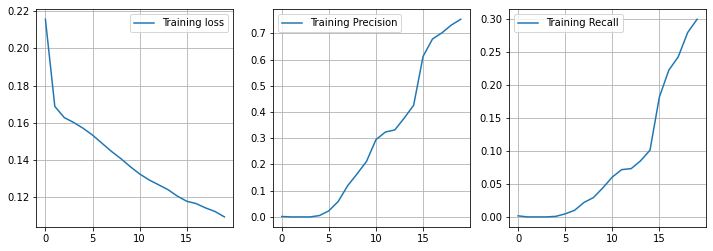

In [124]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history1.history['loss'], label='Training loss')
plt.legend(); plt.grid()
plt.subplot(132)
plt.plot(history1.history['precision_m'], label='Training Precision')
plt.legend(); plt.grid()
plt.subplot(133)
plt.plot(history1.history['recall_m'], label='Training Recall')
plt.legend(); plt.grid()

In [127]:
nr = lambda x: np.round(100*x, 2)

In [129]:
loss, pr, re = model1.evaluate(X_test, y_test, verbose=0)
print (f"Loss: {nr(loss)}%, Precision: {nr(pr)}%, Recall:{nr(re)}%")

Loss: 28.14%, Precision: 5.08%, Recall:1.86%


In [140]:
model1 = make_model(X_train_)
display ( model1.summary() )
history1 = model1.fit(X_train_, y_train_,
                      validation_data=(X_val, y_val),
                      batch_size=128,
                      epochs=20,
                      verbose=1)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 32)                32032     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 32,065
Trainable params: 32,065
Non-trainable params: 0
_________________________________________________________________


None

Epoch 1/20
698/698 [==============================] - 2s 2ms/step - loss: 0.2164 - precision_m: 0.0015 - recall_m: 0.0052 - val_loss: 0.3051 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/20
698/698 [==============================] - 1s 1ms/step - loss: 0.1580 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.2920 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/20
698/698 [==============================] - 1s 2ms/step - loss: 0.1518 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.2894 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/20
698/698 [==============================] - 1s 2ms/step - loss: 0.1480 - precision_m: 0.0115 - recall_m: 0.0027 - val_loss: 0.2905 - val_precision_m: 0.0385 - val_recall_m: 0.0033
Epoch 5/20
698/698 [==============================] - 1s 1ms/step - loss: 0.1445 - precision_m: 0.0301 - recall_m: 0.0079 - val_loss: 0.2966 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Ep

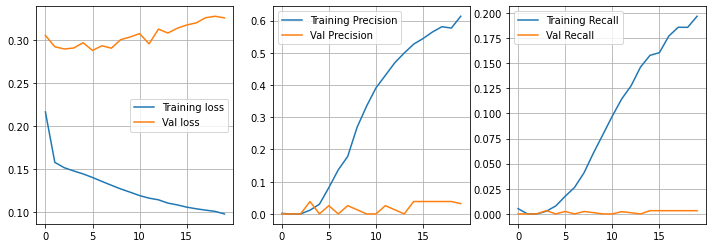

In [142]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history1.history['loss'], label='Training loss')
plt.plot(history1.history['val_loss'], label='Val loss')

plt.legend(); plt.grid()
plt.subplot(132)
plt.plot(history1.history['precision_m'], label='Training Precision')
plt.plot(history1.history['val_precision_m'], label='Val Precision')
plt.legend(); plt.grid()
plt.subplot(133)
plt.plot(history1.history['recall_m'], label='Training Recall')
plt.plot(history1.history['val_recall_m'], label='Val Recall')
plt.legend(); plt.grid()

In [ ]:
th = 0.5
pred = (model1.predict(X_test) > th).ravel().astype('int')
pred[:10]

In [ ]:
ac = accuracy_score(y_test, pred)
pr = precision_score(y_test, pred)
re = recall_score(y_test, pred)
print (ac, pr, re)

In [146]:
import tensorflow as tf
#tf.keras.layers.Embedding(1000, 64, input_length=10))

## LSTM Layers

In [147]:
def make_model2(X, embedding_length = 16):
    model = Sequential()
    model.add(tf.keras.layers.Embedding(MAX_WORDS, embedding_length, input_length=X.shape[1]))
    model.add(LSTM(16, activation='relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(32, input_shape=(X.shape[1],), activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics = [precision_m, recall_m])
    return model

In [148]:
model2 = make_model(X_train_)
display( model2.summary() )

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 32)                32032     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 32,065
Trainable params: 32,065
Non-trainable params: 0
_________________________________________________________________


None

In [149]:
history2 = model2.fit(X_train_, y_train_,
                      validation_data=(X_val, y_val),
                      batch_size=128,
                      epochs=20,
                      verbose=1)


Epoch 1/20
698/698 [==============================] - 2s 2ms/step - loss: 0.2103 - precision_m: 1.4948e-04 - recall_m: 6.5664e-04 - val_loss: 0.3049 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/20
698/698 [==============================] - 1s 2ms/step - loss: 0.1569 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.2865 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/20
698/698 [==============================] - 1s 2ms/step - loss: 0.1504 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.2811 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/20
698/698 [==============================] - 1s 1ms/step - loss: 0.1468 - precision_m: 0.0072 - recall_m: 0.0013 - val_loss: 0.2789 - val_precision_m: 0.0256 - val_recall_m: 0.0021
Epoch 5/20
698/698 [==============================] - 1s 1ms/step - loss: 0.1436 - precision_m: 0.0287 - recall_m: 0.0057 - val_loss: 0.2916 - val_precision_m: 0.0128 - val_recall_m: 0.0013
Ep

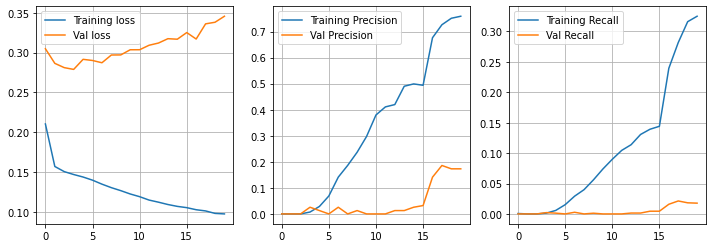

In [150]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history2.history['loss'], label='Training loss')
plt.plot(history2.history['val_loss'], label='Val loss')
plt.legend(); plt.grid()

plt.subplot(132)
plt.plot(history2.history['precision_m'], label='Training Precision')
plt.plot(history2.history['val_precision_m'], label='Val Precision')
plt.legend(); plt.grid()

plt.subplot(133)
plt.plot(history2.history['recall_m'], label='Training Recall')
plt.plot(history2.history['val_recall_m'], label='Val Recall')
plt.legend(); plt.grid()

In [167]:
proba = model2.predict_proba(X_test)

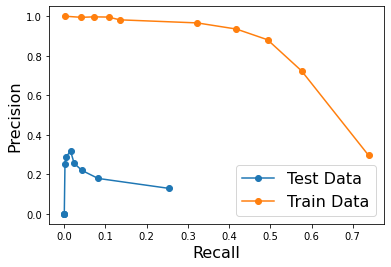

In [197]:
def precision_recall_curve(model, X, y, ax=None, lab="Data"):
    proba = model.predict_proba(X)
    pr = []; re = []
    cutoffs = np.linspace(0.05, 0.99, 10)
    for c in cutoffs:
        preds_c = (proba.flatten()>=c).astype('int')
        pr_ = precision_score(y, preds_c)
        re_ = recall_score(y, preds_c)
        pr.append( pr_ )
        re.append( re_ )
        #print (c, pr_, re_ )
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(6,4))
    ax.plot(re, pr, '-o', label=lab)
    ax.set_xlabel("Recall", fontsize=16)
    ax.set_ylabel("Precision", fontsize=16)
    ax.legend(fontsize=16)
    
    
fig, ax = plt.subplots(1,1, figsize=(6,4))
precision_recall_curve(model2, X_test, y_test, ax=ax, lab = "Test Data")
precision_recall_curve(model2, X_train, y_train, ax=ax, lab = "Train Data")

In [203]:
#1.19.3
!pip3 install numpy==1.19.3

     |████████████████████████████████| 15.9 MB 1.6 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.1
    Uninstalling numpy-1.20.1:
      Successfully uninstalled numpy-1.20.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.5.0 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
qiskit-aqua 0.9.1 requires pandas<=1.2.3, but you have pandas 1.2.4 which is incompatible.
qiskit-aqua 0.9.1 requires scikit-learn<=0.24.1,>=0.20.0, but you have scikit-learn 0.24.2 which is incompatible.


In [204]:
def make_model_GRU(X, embedding_length = 16):
    model = Sequential()
    model.add(tf.keras.layers.Embedding(MAX_WORDS, embedding_length, input_length=X.shape[1]))
    model.add(GRU(128, dropout=0.2, return_sequences=True)) 
    model.add(GRU(128, dropout=0.2))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics = [precision_m, recall_m])
    return model

In [205]:
model3 = make_model_GRU(X_train_)
model3.summary()

NotImplementedError: Cannot convert a symbolic Tensor (gru_1/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [202]:
print (np.__version__)

1.20.1


In [200]:

history3 = model3.fit(X_train_, y_train_,
                      validation_data=(X_val, y_val),
                      batch_size=128,
                      epochs=20,
                      verbose=1)


NameError: name 'model3' is not defined

In [174]:
import nltk

In [175]:
fil = "../04_webapp/english_STOPWORDS"

In [189]:
sw = open(fil, 'r')
set([w.strip("\n") for w in sw.readlines()])
#    .strip('\n'))

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

"i\nme\nmy\nmyself\nwe\nour\nours\nourselves\nyou\nyou're\nyou've\nyou'll\nyou'd\nyour\nyours\nyourself\nyourselves\nhe\nhim\nhis\nhimself\nshe\nshe's\nher\nhers\nherself\nit\nit's\nits\nitself\nthey\nthem\ntheir\ntheirs\nthemselves\nwhat\nwhich\nwho\nwhom\nthis\nthat\nthat'll\nthese\nthose\nam\nis\nare\nwas\nwere\nbe\nbeen\nbeing\nhave\nhas\nhad\nhaving\ndo\ndoes\ndid\ndoing\na\nan\nthe\nand\nbut\nif\nor\nbecause\nas\nuntil\nwhile\nof\nat\nby\nfor\nwith\nabout\nagainst\nbetween\ninto\nthrough\nduring\nbefore\nafter\nabove\nbelow\nto\nfrom\nup\ndown\nin\nout\non\noff\nover\nunder\nagain\nfurther\nthen\nonce\nhere\nthere\nwhen\nwhere\nwhy\nhow\nall\nany\nboth\neach\nfew\nmore\nmost\nother\nsome\nsuch\nno\nnor\nnot\nonly\nown\nsame\nso\nthan\ntoo\nvery\ns\nt\ncan\nwill\njust\ndon\ndon't\nshould\nshould've\nnow\nd\nll\nm\no\nre\nve\ny\nain\naren\naren't\ncouldn\ncouldn't\ndidn\ndidn't\ndoesn\ndoesn't\nhadn\nhadn't\nhasn\nhasn't\nhaven\nhaven't\nisn\nisn't\nma\nmightn\nmightn't\nmustn\nmus

In [190]:
#import sklearn
!pip3 install scikit-learn --upgrade

In [191]:
import sklearn

In [192]:
sklearn.__version__

'0.24.1'

In [193]:
import pandas 
pandas.__version__

'1.2.3'

In [195]:
import pickle